In [1]:
#importing required libraries
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5

In [2]:
#getting training images (downloaded from https://zenodo.org/record/1133969#.YWpD1BpByIs)
train_images_path = r'C:\Users\harsh\OneDrive\Desktop\ml cs460 project\craters\train_images.hdf5'
f = h5.File(train_images_path,'r')

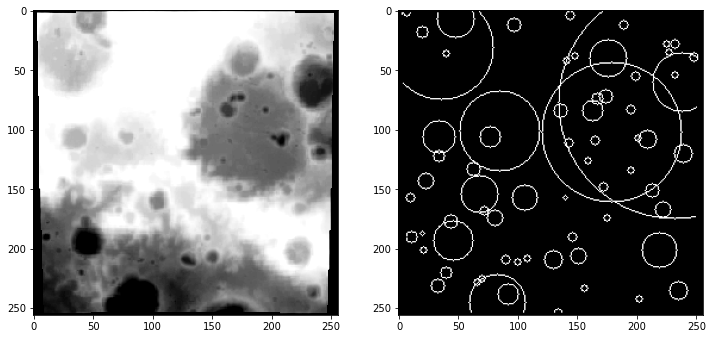

In [3]:
#showing sample dem-target pair
fig = plt.figure(figsize=[12, 6])
[ax1, ax2] = fig.subplots(1,2)
ax1.imshow(f['input_images'][60][...], origin='upper', cmap='Greys_r', vmin=120, vmax=200)
ax2.imshow(f['target_masks'][60][...], origin='upper', cmap='Greys_r')
plt.show()

In [4]:
#converting hdf5 columns to numpy array and taking a portion as training set
#training set of of size 5000 images and masks
training_images = np.array(f['input_images'][10000:15000])
training_masks = np.array(f['target_masks'][10000:15000])

In [5]:
#validation images and masks (picking 2000 images and masks)
valid_images = np.array(f['input_images'][19000:21000])
valid_masks =  np.array(f['target_masks'][19000:21000])

In [6]:
#first import the functions we need from keras
from keras.models import Model
from keras.layers import BatchNormalization,Input
from keras.layers.core import Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPool2D
from keras.layers.merge import concatenate

In [27]:

#function that passes input through 2 3*3 conv layers
def u_conv(inputs,kernels):
    l = Conv2D(kernels,(3,3),activation = 'relu', padding = 'same')(inputs) 
    l = Conv2D(kernels,(3,3),activation = 'relu', padding = 'same')(l)
    l = BatchNormalization()(l) # adding batch normalization to ease training
    return l

#function that combines pooling step and convolution step
def u_conv_and_pool(inputs,kernels):
    o = u_conv(inputs,kernels)
    p = MaxPool2D((2,2))(o)
    p = Dropout(0.15)(p) #dropouts also added
    
    return o,p
    
#function to upsample images (using transpose convolution)    
def upsample(inputs,res_inputs,kernels):
    l = Conv2DTranspose(kernels,(3,3),strides = (2,2),padding = 'same')(inputs)
    l = concatenate([l,res_inputs])
    l = u_conv(l,kernels)
    return l
    
def make_short_unet(input_shape,k):
    inputs = Input(input_shape)
    
    res1, p1 = u_conv_and_pool(inputs, k) 
    res2, p2 = u_conv_and_pool(p1, 2*k)

    middle =  u_conv(p2, 4*k)

    d1 = upsample(middle, res2, 2*k)
    d2 = upsample(d1, res1, k)
   

    
    
    output = Conv2D(1, (1,1), padding="same", activation="sigmoid")(d2)
    
    model = Model(inputs,output,name = 'Crater_Short_U_Net')
    return model  

In [28]:
image_shape = (256,256,1)
k = 16
unet = make_short_unet(image_shape,k)
unet.summary()

Model: "Crater_Short_U_Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 256, 256, 16) 160         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 256, 256, 16) 2320        conv2d_41[0][0]                  
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 256, 256, 16) 64          conv2d_42[0][0]                  
_________________________________________________________________________________

In [29]:
#setting the loss we want to optimise our model with (using binary cross entropy because at the pixel level this problem is a two class classfication)
unet.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss=keras.losses.BinaryCrossentropy(),metrics=[keras.metrics.BinaryAccuracy(threshold = 0.5)])

In [30]:
valid_data = (valid_images,valid_masks)
history = unet.fit(x=training_images,y=training_masks,validation_data = valid_data,epochs = 2)

Epoch 1/2
157/157 [==============================] - 1595s 10s/step - loss: 0.5023 - binary_accuracy: 0.9131 - val_loss: 0.3144 - val_binary_accuracy: 0.9711
Epoch 2/2
157/157 [==============================] - 1670s 11s/step - loss: 0.2014 - binary_accuracy: 0.9709 - val_loss: 0.1383 - val_binary_accuracy: 0.9713


In [31]:
#predictions for test set(taking first 1000 as test set)
test_images = np.array(f['input_images'][0:1000])
test_preds = unet.predict(test_images)

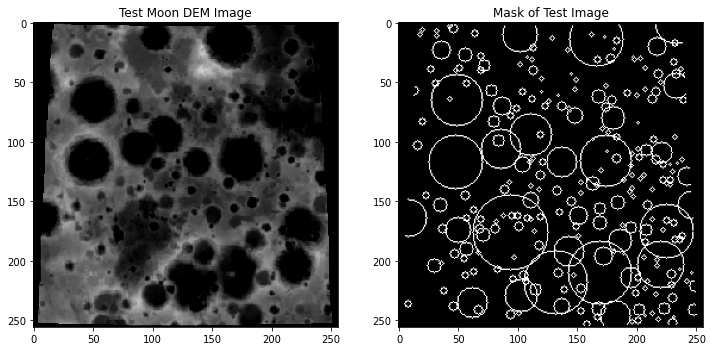

In [32]:
#test input image and mask
test = test_preds[10]
fig = plt.figure(figsize=[12, 6])
[ax1,ax2] = fig.subplots(1,2)
ax1.imshow(f['input_images'][10][...], origin='upper', cmap='Greys_r', vmin=120, vmax=200)
ax2.imshow(f['target_masks'][10][...], origin='upper', cmap='Greys_r')
ax1.set_title('Test Moon DEM Image')
ax2.set_title('Mask of Test Image')
plt.show()

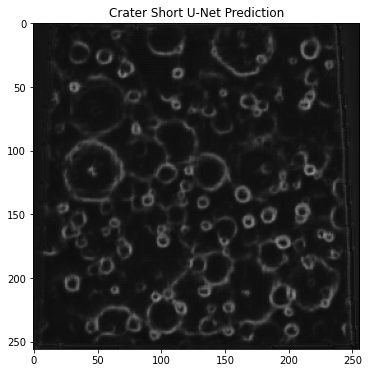

In [33]:
#Showing sample output of Unet
fig = plt.figure(figsize=[12, 6])
ax3 = fig.subplots(1,1)
ax3.imshow(test, origin='upper', cmap='Greys_r', vmin=0, vmax=1)
ax3.set_title('Crater Short U-Net Prediction')
plt.show()

# Comparing with the normal sized u-net, across two epochs, the shorter u-net's validation loss is actually lower. The removal of two layers doesn't really affect the model.